<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection-Projects/blob/main/Flower_Recognition_Challenges_part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, cv2
import copy
import time
import tqdm
import warnings
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, preprocessing

In [ ]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip

#Tensorflow
###Unfortunately, the ram crushes in the Colab so I can't train it with TensorFlow, if you have more ram, feel free to run this code.

##Data

###1.Get Data

In [ ]:
path_folder = '/content/flowers'

size = 224
data = []
label = []
data_names = []
id = 0
for folder in tqdm.tqdm(os.listdir(path_folder)):
  for files in tqdm.tqdm(os.listdir(os.path.join(path_folder, folder))):
    if files.endswith('jpg'):
      label.append(folder)
      img_path = os.path.join(path_folder, folder, files)
      data_names.append((id, img_path))
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      im = cv2.resize(img, (size, size))
      data.append(im)
      id += 1

In [ ]:
data = np.array(data)/255

In [ ]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(label)
y = tf.keras.utils.to_categorical(y)

In [ ]:
data.shape

(4317, 224, 224, 3)

In [ ]:
label.shape, y.shape

((4317,), (4317, 5))

In [ ]:
len(data_names)

4317

###2.Preprocess Data

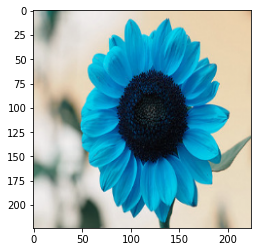

In [ ]:
plt.imshow(data[0])

In [ ]:
def plot_img(id):
  img_label = label[id]
  img = data[id]
  plt.imshow(img)
  plt.title(img_label)  

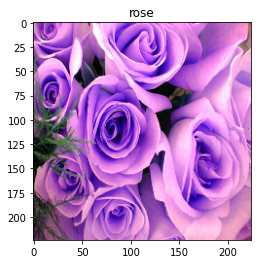

In [ ]:
rnd = np.random.randint(0, len(data))
plot_img(rnd)

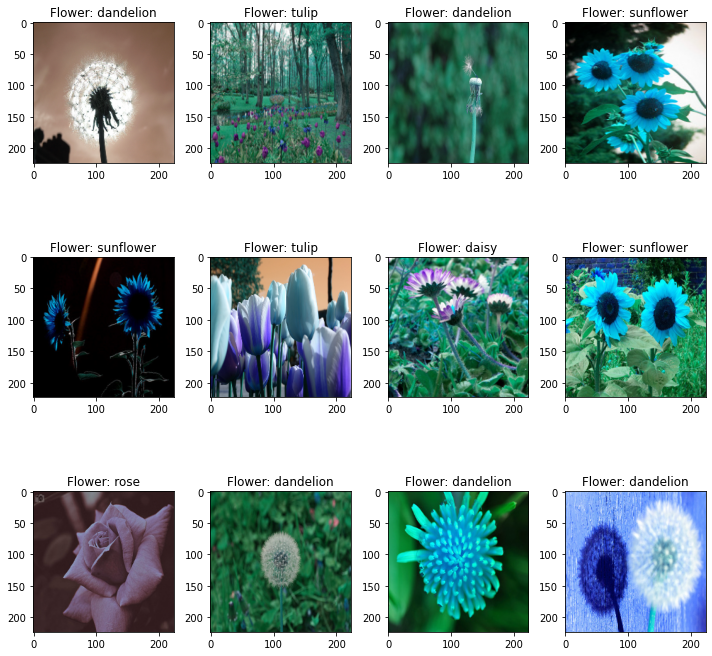

In [ ]:
row=3
col=4
fig, ax = plt.subplots(row, col)
fig.set_size_inches(10, 10)
for r in range(row):
  for c in range(col):
    rnd = np.random.randint(0, len(data))
    ax[r, c].imshow(data[rnd])
    ax[r, c].set_title(f'Flower: {label[rnd]}')
plt.tight_layout()

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y, random_state=32, test_size=0.2)

##Model

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
base_model.trainable=False

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14,847,301
Trainable params: 132,613
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(x_train,
                     y_train,
                     batch_size=32,
                     epochs=100,
                     validation_data=(x_test, y_test),
                     verbose=1,
                    steps_per_epoch=x_train.shape[0]//32)

In [ ]:
def plot_history(history, loss=True):

  num_epochs = len(history['loss'])
  title = 'loss' if loss else 'accuracy'
  plt.title(f'Train Validation {title}')
  plt.plot(range(1, num_epochs+1), history[f'{title}'], label='Train')
  plt.plot(range(1, num_epochs+1), history[f'val_{title}'], label='Validation')
  plt.xlabel('Trainig Epochs')
  plt.ylabel(title)
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
plot_history(history.history, False)

In [ ]:
plot_history(history.history, True)

# PyTorch

In [ ]:
data_generator = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range = 0.4,
                                   height_shift_range = 0.4,
                                   zoom_range=0.3,
                                   rotation_range=20,
                                   )

image_size = 224
batch_size = 10
train_generator = data_generator.flow_from_directory(
        '../input/flowers-recognition/flowers/flowers/',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical')

num_classes = len(train_generator.class_indices)
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
count = sum([len(files) for r, d, files in os.walk("../input/flowers-recognition/flowers/flowers/")])

model.fit_generator(
        train_generator,
        steps_per_epoch=int(count/batch_size) + 1,
        epochs=10)